# Load data

In [25]:
from pandas import DataFrame, read_csv

# load the data
def load_data(
        data_file: str,
        n_rows: int | None = None,
) -> DataFrame:
    return read_csv(data_file, index_col='row_index', nrows=n_rows)

In [26]:
import pandas as pd

# train_data = file_manager.load_training_data()

# TODO
train_file = '../X_train.csv'
test_file = '../X_test.csv'
n_rows = 100_000

test_data = load_data(test_file)
tiny_train_data = load_data(train_file, n_rows=n_rows)
# train_data = load_data(train_file)

C:\Users\serra\AppData\Local\Temp\ipykernel_30880\710385439.py:8: DtypeWarning: Columns (108,110,111,115,117,118,122,124,125,130,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(data_file, index_col='row_index', nrows=n_rows)
C:\Users\serra\AppData\Local\Temp\ipykernel_30880\710385439.py:8: DtypeWarning: Columns (108,110,111,115,117,118,122,124,125,130,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(data_file, index_col='row_index', nrows=n_rows)


# Split raw data by variable category (piezo, weather, ...)

We are only interested in training data.

In [27]:
from pandas import DataFrame

# Function to extract variable category
def extract_category(
        df: DataFrame,
        category: str,
) -> DataFrame:
    return df[df.columns[df.columns.str.startswith(category)]]

In [28]:
# Example values with meteo variables
hydro_variables = extract_category(tiny_train_data, 'hydro')
hydro_variables.head()
hydro_variables["hydro_status_label"].unique()

array(['Donnée validée', 'Donnée pré-validée', 'Donnée brute',
       'Donnée corrigée'], dtype=object)

In [29]:
# display information about the hydrology variables
hydro_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 39 to 3293997
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   hydro_station_code             100000 non-null  object 
 1   hydro_observation_date_elab    100000 non-null  object 
 2   hydro_observation_result_elab  100000 non-null  float64
 3   hydro_status_code              100000 non-null  int64  
 4   hydro_status_label             100000 non-null  object 
 5   hydro_method_code              100000 non-null  int64  
 6   hydro_method_label             100000 non-null  object 
 7   hydro_qualification_code       100000 non-null  int64  
 8   hydro_qualification_label      100000 non-null  object 
 9   hydro_longitude                100000 non-null  float64
 10  hydro_latitude                 100000 non-null  float64
 11  hydro_hydro_quantity_elab      100000 non-null  object 
dtypes: float64(3), int64(3), object(6

# Hydrology Information

### 1.1. Unique values
Values with one unique values can be observed so we can drop them.

In [30]:
# Check number of different values
hydro_variables.nunique()

hydro_station_code                1304
hydro_observation_date_elab       1125
hydro_observation_result_elab    26946
hydro_status_code                    4
hydro_status_label                   4
hydro_method_code                    1
hydro_method_label                   1
hydro_qualification_code             3
hydro_qualification_label            3
hydro_longitude                   1294
hydro_latitude                    1294
hydro_hydro_quantity_elab            2
dtype: int64

In [31]:
# Columns to drop
unique_columns = [
    "hydro_method_code",
    "hydro_method_label"
]

# Create the new DataFrame excluding the specified columns
hydro_variables = hydro_variables.drop(columns=unique_columns, errors='ignore')
hydro_variables.head()
hydro_variables["hydro_status_label"].unique()

array(['Donnée validée', 'Donnée pré-validée', 'Donnée brute',
       'Donnée corrigée'], dtype=object)

### 1.2. Introductory visualization

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# function to plot the correlation matrix
def plot_correlation_matrix(dataframe, numerical_columns, figsize=(12, 10)):
    correlation_matrix = dataframe[numerical_columns].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()
    return correlation_matrix

In [33]:
import numpy as np

# function to display pairs of features according to their correlation
def get_sorted_correlation_pairs(correlation_matrix):
    """
    Converts a correlation matrix into a sorted list of feature pairs based on correlation values.
    
    Parameters:
    - correlation_matrix: pandas.DataFrame, the correlation matrix to process.
    
    Returns:
    - pandas.DataFrame: A DataFrame containing sorted correlation pairs with absolute correlation values.
    """
    # Remove the lower triangle and diagonal
    correlation_matrix = correlation_matrix.where(
        ~np.tril(np.ones(correlation_matrix.shape)).astype(bool)
    )

    # Convert to long format
    correlation_pairs = correlation_matrix.stack().reset_index()
    correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation Score']
    correlation_pairs['Absolute Correlation'] = np.abs(correlation_pairs['Correlation Score'])

    # Sort by absolute correlation value
    sorted_correlation_pairs = correlation_pairs.sort_values(by='Absolute Correlation', ascending=False)

    return sorted_correlation_pairs

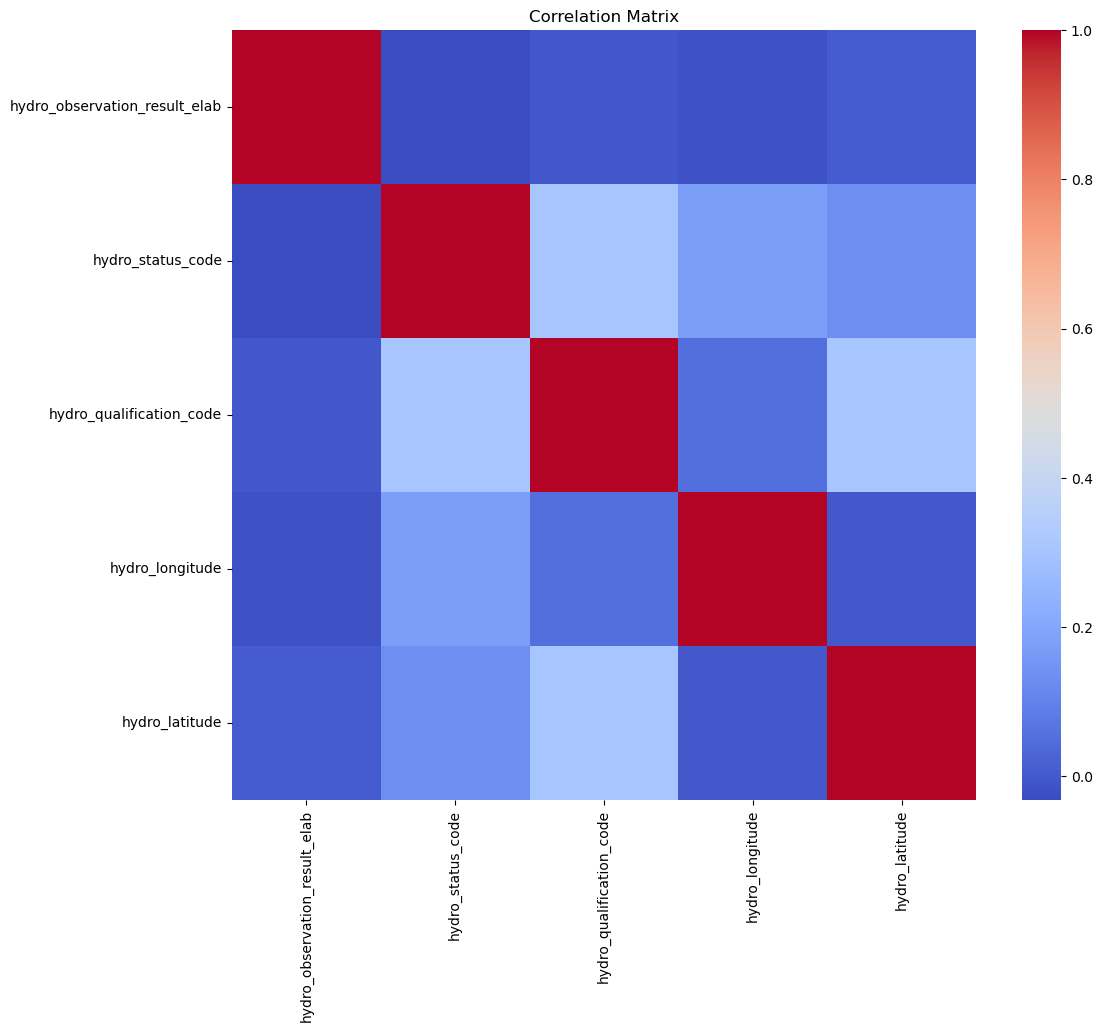

In [34]:
# list all numerical values except price to have only the features
numerical_hydro = hydro_variables.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = plot_correlation_matrix(hydro_variables, numerical_hydro)

In [35]:
# display the correlation between features (most correlated first)
print(get_sorted_correlation_pairs(correlation_matrix))

                       Feature 1                 Feature 2  Correlation Score  \
4              hydro_status_code  hydro_qualification_code           0.306222   
8       hydro_qualification_code            hydro_latitude           0.304509   
5              hydro_status_code           hydro_longitude           0.174868   
6              hydro_status_code            hydro_latitude           0.132793   
7       hydro_qualification_code           hydro_longitude           0.050428   
0  hydro_observation_result_elab         hydro_status_code          -0.031895   
2  hydro_observation_result_elab           hydro_longitude          -0.018865   
1  hydro_observation_result_elab  hydro_qualification_code          -0.007280   
3  hydro_observation_result_elab            hydro_latitude           0.005601   
9                hydro_longitude            hydro_latitude          -0.001868   

   Absolute Correlation  
4              0.306222  
8              0.304509  
5              0.174868  
6   

In [36]:
# Columns to drop
useless_columns = [
    "hydro_station_code",
    "hydro_qualification_label",
    "hydro_hydro_quantity_elab"
]

# Create the new DataFrame excluding the specified columns
hydro_variables = hydro_variables.drop(columns=useless_columns, errors='ignore')
hydro_variables.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude
row_index,,,,,,,
39,2020-01-01,2377.0,16,Donnée validée,20,4.014893,49.698327
62,2020-01-01,2878.0,12,Donnée pré-validée,20,2.623428,46.726831
148,2020-01-01,34501.0,4,Donnée brute,12,1.680690,43.253505
177,2020-01-01,1407.0,16,Donnée validée,20,2.837573,43.342220
179,2020-01-01,87473.0,16,Donnée validée,12,2.855418,43.240145


In [37]:
# Convert to datetime
from datetime import datetime

def days_since_start_of_2020(date_str):
    # Convert the date into a datetime object
    parsed_date = pd.to_datetime(date_str, format='%Y-%m-%d')
    
    # Fix the reference date (1st january 2022)
    ref_date = datetime(2020, 1, 1)
    
    # Compute the difference between current date and reference date
    delta = parsed_date - ref_date
    
    # Return the number of days between current and reference date
    return delta.days

# Display hydrology information including the days_since_start_of_2020 computation
hydro_variables['hydro_observation_date_elab'] = hydro_variables['hydro_observation_date_elab'].apply(days_since_start_of_2020)
hydro_variables.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude
row_index,,,,,,,
39,0,2377.0,16,Donnée validée,20,4.014893,49.698327
62,0,2878.0,12,Donnée pré-validée,20,2.623428,46.726831
148,0,34501.0,4,Donnée brute,12,1.680690,43.253505
177,0,1407.0,16,Donnée validée,20,2.837573,43.342220
179,0,87473.0,16,Donnée validée,12,2.855418,43.240145


In [38]:
# Define mapping values for hydro_status_label column
mapping = {
    'Donnée validée': 1,
    'Donnée pré-validée': 2,
    'Donnée brute': 3,
    'Donnée corrigée': 4
}

# Apply the mapping to the column
hydro_variables['hydro_status_label'] = hydro_variables['hydro_status_label'].map(mapping)
hydro_variables.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude
row_index,,,,,,,
39,0,2377.0,16,1,20,4.014893,49.698327
62,0,2878.0,12,2,20,2.623428,46.726831
148,0,34501.0,4,3,12,1.680690,43.253505
177,0,1407.0,16,1,20,2.837573,43.342220
179,0,87473.0,16,1,12,2.855418,43.240145


## Random Forest

In [39]:
import pandas as pd

# Function to drop useless or redundant columns in the hydrology category
def drop_columns_if_exist(dataset: pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    """
    Drops the specified columns from the dataset if they exist.

    Parameters:
    - dataset: pd.DataFrame, the dataset from which columns will be dropped.
    - columns_to_drop: list, the list of column names to drop.

    Returns:
    - pd.DataFrame: The dataset with specified columns dropped.
    """
    columns_to_drop = [
        "hydro_station_code",
        "hydro_qualification_label",
        "hydro_hydro_quantity_elab",
        "hydro_method_code",
        "hydro_method_label"
    ]
    
    return dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns], errors='ignore')

In [40]:
import pandas as pd
from pandas import DataFrame

# Function to include the groundwater levels to predict in the dataset
def extract_category_with_extra(
        df: DataFrame,
        category: str,
        extra_columns: list
) -> DataFrame:
    """
    Extracts columns starting with a specific category and includes additional specified columns.

    Parameters:
    - df: pandas.DataFrame, the source dataset.
    - category: str, the prefix for columns to extract.
    - extra_columns: list, additional columns to include.

    Returns:
    - pandas.DataFrame: A DataFrame with the selected columns.
    """
    category_columns = df.columns[df.columns.str.startswith(category)].tolist()
    columns_to_keep = category_columns + [col for col in extra_columns if col in df.columns]
    return df[columns_to_keep]



In [41]:
# Add the column to predict
extra_columns = ["piezo_groundwater_level_category"]
df = extract_category_with_extra(tiny_train_data, 'hydro', extra_columns)

# Display the filtered DataFrame
df.head()

,hydro_station_code,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_method_code,hydro_method_label,hydro_qualification_code,hydro_qualification_label,hydro_longitude,hydro_latitude,hydro_hydro_quantity_elab,piezo_groundwater_level_category
row_index,,,,,,,,,,,,,
39,H710202001,2020-01-01,2377.0,16,Donnée validée,12,Interpolation,20,Bonne,4.014893,49.698327,QmM,Low
62,K543302001,2020-01-01,2878.0,12,Donnée pré-validée,12,Interpolation,20,Bonne,2.623428,46.726831,QmJ,High
148,O165293003,2020-01-01,34501.0,4,Donnée brute,12,Interpolation,12,Douteuse,1.680690,43.253505,QmM,Very High
177,Y160506001,2020-01-01,1407.0,16,Donnée validée,12,Interpolation,20,Bonne,2.837573,43.342220,QmJ,High
179,Y145201001,2020-01-01,87473.0,16,Donnée validée,12,Interpolation,12,Douteuse,2.855418,43.240145,QmM,Low


In [42]:
# Apply the function to drop non-necessary columns
df_clean = drop_columns_if_exist(df, [])

# Drop rows containing missing values
df_clean = df_clean.dropna()

# Display the updated DataFrame
df_clean.head()

,hydro_observation_date_elab,hydro_observation_result_elab,hydro_status_code,hydro_status_label,hydro_qualification_code,hydro_longitude,hydro_latitude,piezo_groundwater_level_category
row_index,,,,,,,,
39,2020-01-01,2377.0,16,Donnée validée,20,4.014893,49.698327,Low
62,2020-01-01,2878.0,12,Donnée pré-validée,20,2.623428,46.726831,High
148,2020-01-01,34501.0,4,Donnée brute,12,1.680690,43.253505,Very High
177,2020-01-01,1407.0,16,Donnée validée,20,2.837573,43.342220,High
179,2020-01-01,87473.0,16,Donnée validée,12,2.855418,43.240145,Low


In [43]:
# Ensure that there are no missing values anymore
df_clean.isna().sum()

hydro_observation_date_elab         0
hydro_observation_result_elab       0
hydro_status_code                   0
hydro_status_label                  0
hydro_qualification_code            0
hydro_longitude                     0
hydro_latitude                      0
piezo_groundwater_level_category    0
dtype: int64

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for a Regression problem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

var = "piezo_groundwater_level_category"

# 1. Encode categorical variables with LabelEncoder
le = LabelEncoder()
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = le.fit_transform(df_clean[col])

# 2. Separate the features to work with (X) from the feature to predict (y)
X = df_clean.drop(columns=[var])
y = df_clean[var]


                         Feature  Importance
0    hydro_observation_date_elab    0.351876
1  hydro_observation_result_elab    0.308064
5                hydro_longitude    0.157639
6                 hydro_latitude    0.156141
4       hydro_qualification_code    0.011912
2              hydro_status_code    0.007212
3             hydro_status_label    0.007156


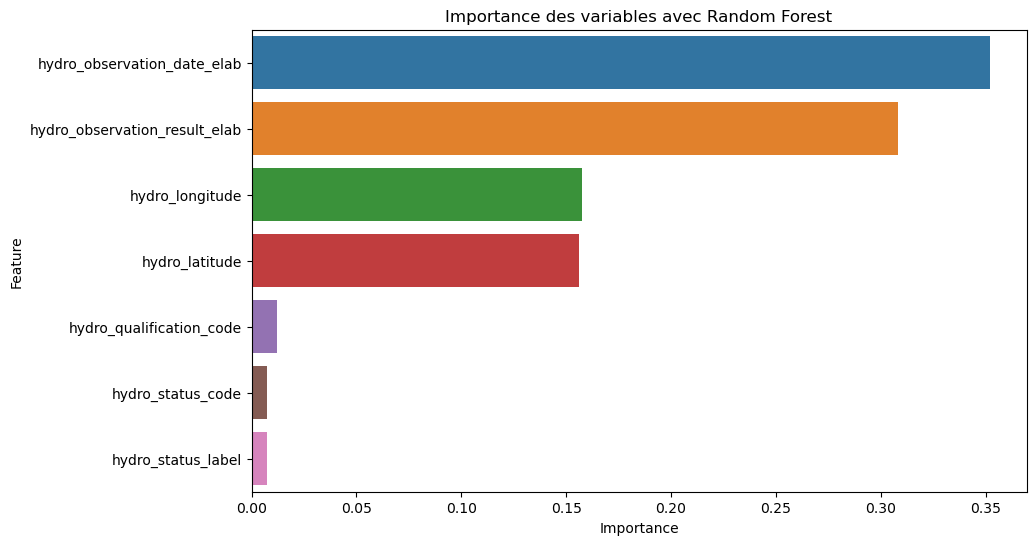

In [ ]:
# 3. Separate the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Apply Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Display feature importance
importances = model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by decreasing feature importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display results
print(feature_importance)

# 6. Display feature importance as a graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importance des variables avec Random Forest')
plt.show()